# **Goal is to train a linear regression model to predict the release year of a song given a set of audio features.**

#### **Load and check the data **

In [2]:
import os.path
baseDir = os.path.join('data')
inputPath = os.path.join('cs190', 'millionsong.txt')
fileName = os.path.join(baseDir, inputPath)
numPartitions = 2
rawData = sc.textFile(fileName, numPartitions)

In [3]:
numPoints = rawData.count()
print numPoints
samplePoints = rawData.take(5)
print samplePoints

6724
[u'2001.0,0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817', u'2001.0,0.854411946129,0.604124786151,0.593634078776,0.495885413963,0.266307830936,0.261472105188,0.506387076327,0.464453565511,0.665798573683,0.542968988766,0.58044428577,0.445219373624', u'2001.0,0.908982970575,0.632063159227,0.557428975183,0.498263761394,0.276396052336,0.312809861625,0.448530069406,0.448674249968,0.649791323916,0.489868662682,0.591908113534,0.4500023818', u'2001.0,0.842525219898,0.561826888508,0.508715259692,0.443531142139,0.296733836002,0.250213568176,0.488540873206,0.360508747659,0.575435243185,0.361005878554,0.678378718617,0.409036786173', u'2001.0,0.909303285534,0.653607720915,0.585580794716,0.473250503005,0.251417011835,0.326976795524,0.40432273022,0.371154511756,0.629401917965,0.482243251755,0.566901413923,0.463373691946']


In [4]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np

In [5]:
def parsePoint(line):
    data = line.split(',')
    return LabeledPoint(data[0], data[1:])

parsedSamplePoints = map(parsePoint,samplePoints)
firstPointFeatures = parsedSamplePoints[0].features
firstPointLabel = parsedSamplePoints[0].label
print firstPointFeatures, firstPointLabel
d = len(firstPointFeatures)
print d

[0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817] 2001.0
12


#### **Visualization : Features**
####Here we will look at the raw features for 50 data points by generating a heatmap that visualizes each feature on a grey-scale and shows the variation of each feature across the 50 sample data points.  The features are all between 0 and 1, with values closer to 1 represented via darker shades of grey.

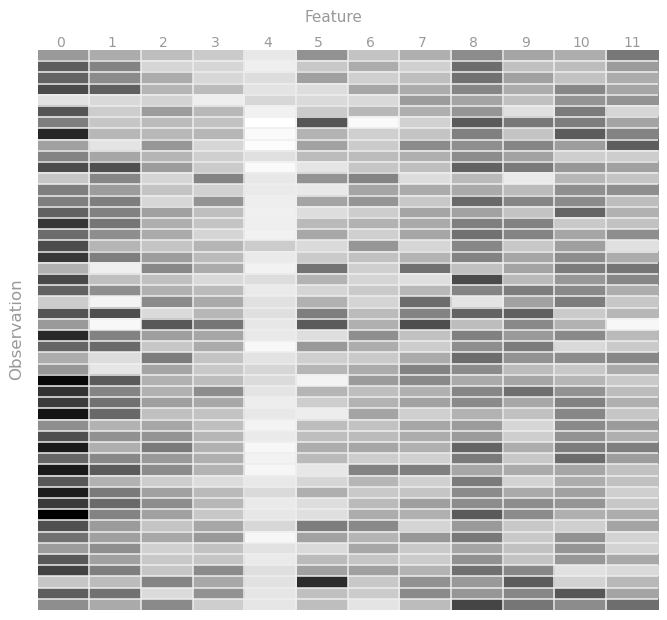

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
sampleMorePoints = rawData.takeSample(False, 50)

parsedSampleMorePoints = map(parsePoint, sampleMorePoints)
dataValues = map(lambda lp: lp.features.toArray(), parsedSampleMorePoints)

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

# generate layout and plot
fig, ax = preparePlot(np.arange(.5, 11, 1), np.arange(.5, 49, 1), figsize=(8,7), hideLabels=True,
                      gridColor='#eeeeee', gridWidth=1.1)
image = plt.imshow(dataValues,interpolation='nearest', aspect='auto', cmap=cm.Greys)
for x, y, s in zip(np.arange(-.125, 12, 1), np.repeat(-.75, 12), [str(x) for x in range(12)]):
    plt.text(x, y, s, color='#999999', size='10')
plt.text(4.7, -3, 'Feature', color='#999999', size='11'), ax.set_ylabel('Observation')
pass

#### ** Find the range of song years **

In [7]:
parsedDataInit = rawData.map(parsePoint)
onlyLabels = parsedDataInit.map(lambda data: data.label)
minYear = onlyLabels.min()
maxYear = onlyLabels.max()
print maxYear, minYear

2011.0 1922.0


#### **Shift labels **
####The labels are years in the 1900s and 2000s.  In learning problems, it is often natural to shift labels such that they start from zero. 

In [8]:
parsedData = parsedDataInit.map(lambda data: LabeledPoint(data.label - minYear, data.features))
print type(parsedData.take(1)[0])
print '\n{0}'.format(parsedData.take(1))

<class 'pyspark.mllib.regression.LabeledPoint'>

[LabeledPoint(79.0, [0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817])]


#### ** Visualization : Shifting labels **
#### We will look at the labels before and after shifting them.  Both scatter plots below visualize tuples storing i) a label value and ii) the number of training points with this label.  The first scatter plot uses the initial labels, while the second one uses the shifted labels.  Note that the two plots look the same except for the labels on the x-axis.

(<matplotlib.text.Text at 0xb1ea032c>, <matplotlib.text.Text at 0xb0db02ec>)

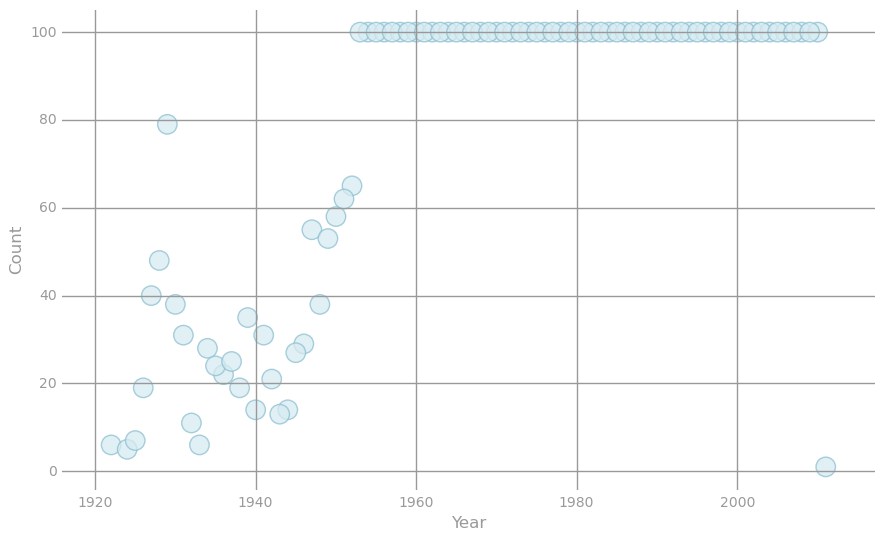

In [9]:
oldData = (parsedDataInit
           .map(lambda lp: (lp.label, 1))
           .reduceByKey(lambda x, y: x + y)
           .collect())
x, y = zip(*oldData)

fig, ax = preparePlot(np.arange(1920, 2050, 20), np.arange(0, 150, 20))
plt.scatter(x, y, s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
ax.set_xlabel('Year'), ax.set_ylabel('Count')

(<matplotlib.text.Text at 0xb0d335ec>, <matplotlib.text.Text at 0xb0d4082c>)

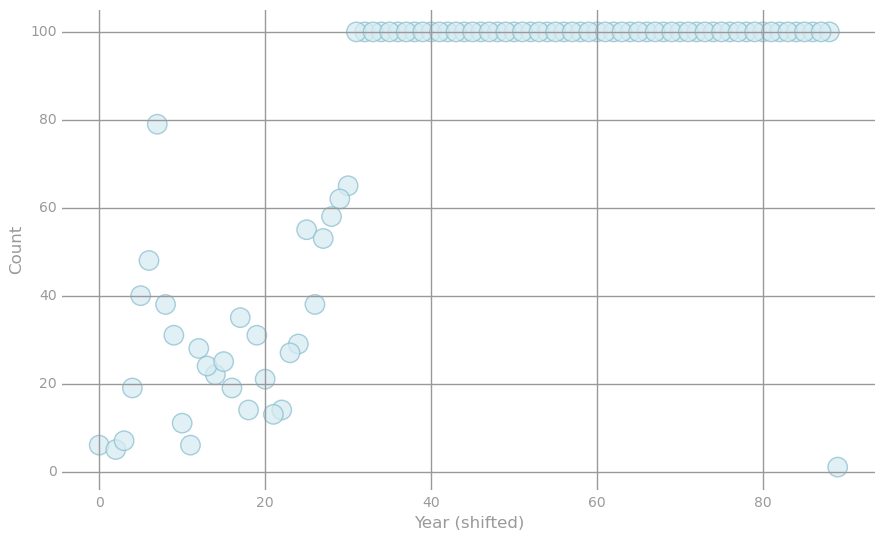

In [10]:
newData = (parsedData
           .map(lambda lp: (lp.label, 1))
           .reduceByKey(lambda x, y: x + y)
           .collect())
x, y = zip(*newData)
fig, ax = preparePlot(np.arange(0, 120, 20), np.arange(0, 120, 20))
plt.scatter(x, y, s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
ax.set_xlabel('Year (shifted)'), ax.set_ylabel('Count')

#### ** Training, validation, and test sets **

In [11]:
weights = [.8, .1, .1]
seed = 42
parsedTrainData, parsedValData, parsedTestData = parsedData.randomSplit(weights,seed)
parsedTrainData.cache()
parsedValData.cache()
parsedTestData.cache()
nTrain = parsedTrainData.count()
nVal = parsedValData.count()
nTest = parsedTestData.count()

print nTrain, nVal, nTest, nTrain + nVal + nTest
print parsedData.count()

5371 682 671 6724
6724


### ** Create and evaluate a baseline model **

#### **Average label **

In [12]:
averageTrainYear = (parsedTrainData.map(lambda x: x.label).reduce(lambda x,y:x+y)/parsedTrainData.count())
print averageTrainYear

53.9316700801


#### **Root mean squared error **

In [15]:
def calcRMSE(labelsAndPreds):
    squared_error_sum = labelsAndPreds.map(lambda x:np.square(x[0]-x[1])).reduce(lambda x, y: x + y)
    return np.sqrt(squared_error_sum / labelsAndPreds.count())

#### **Training, validation and test RMSE **

In [16]:
labelsAndPredsTrain = parsedTrainData.map(lambda d: (d.label, averageTrainYear))
rmseTrainBase = calcRMSE(labelsAndPredsTrain)

labelsAndPredsVal = parsedValData.map(lambda d: (d.label, averageTrainYear))
rmseValBase = calcRMSE(labelsAndPredsVal)

labelsAndPredsTest = parsedTestData.map(lambda d: (d.label, averageTrainYear))
rmseTestBase = calcRMSE(labelsAndPredsTest)

print 'Baseline Train RMSE = {0:.3f}'.format(rmseTrainBase)
print 'Baseline Validation RMSE = {0:.3f}'.format(rmseValBase)
print 'Baseline Test RMSE = {0:.3f}'.format(rmseTestBase)

Baseline Train RMSE = 21.306
Baseline Validation RMSE = 21.586
Baseline Test RMSE = 22.137


#### ** Visualization : Predicted vs. actual **
#### We will visualize predictions on the validation dataset. The scatter plots below visualize tuples storing i) the predicted value and ii) true label.The plot uses the baseline predictor (i.e., `averageTrainYear`) for all predicted values.

In [34]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
norm = Normalize()

In [36]:
po = np.arange(len(actual))

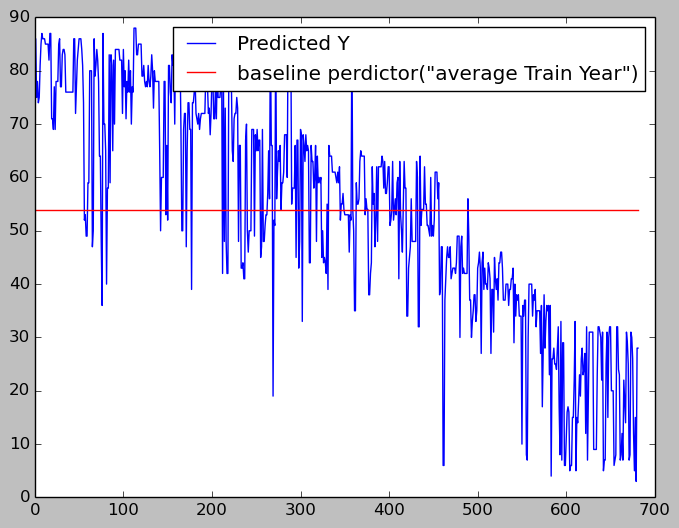

In [45]:
plt.plot(po,actual,c='b',label='Predicted Y')
pass
plt.plot(po,predictions,c='r',label='baseline perdictor("average Train Year")')
pass
plt.legend(loc="upper right")
pass

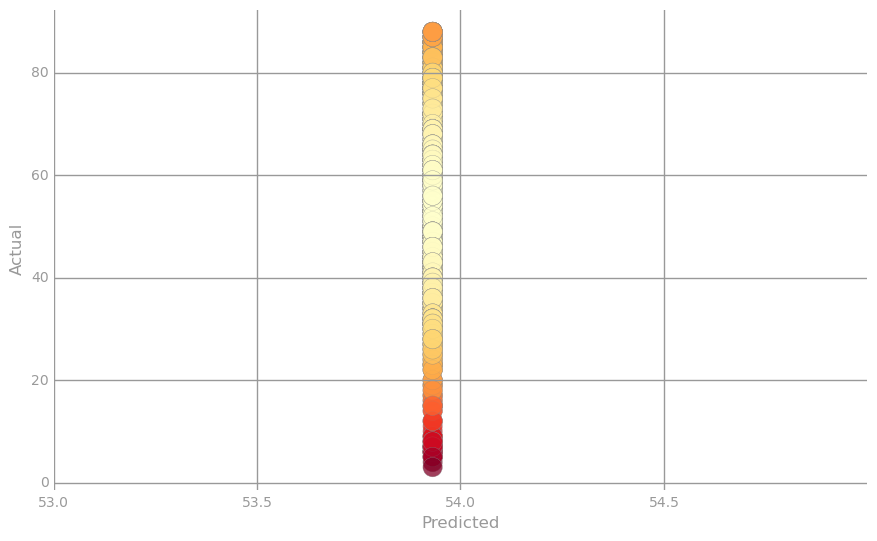

In [46]:
predictions = np.asarray(parsedValData
                         .map(lambda lp: averageTrainYear)
                         .collect())
error = np.asarray(parsedValData
                   .map(lambda lp: (lp.label, averageTrainYear))
                   .map(lambda (l, p): np.square(l-p))
                   .collect())
norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(53.0, 55.0, 0.5), np.arange(0, 100, 20))
ax.set_xlim(53, 55)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')
pass

### ** Train (via gradient descent) and evaluate a linear regression model **

In [21]:
from pyspark.mllib.linalg import DenseVector

In [24]:
def gradientSummand(weights, lp):
    return (weights.dot(lp.features) - lp.label) * lp.features

#### **  Use weights to make predictions **

In [26]:
def getLabeledPrediction(weights, observation):
    return (observation.label, weights.dot(observation.features))

#### ** Gradient descent **

In [29]:
# TODO: Replace <FILL IN> with appropriate code
def linregGradientDescent(trainData, numIters):
    n = trainData.count()
    d = len(trainData.take(1)[0].features)
    w = np.zeros(d)
    alpha = 1.0
    errorTrain = np.zeros(numIters)
    for i in range(numIters):
        labelsAndPredsTrain = trainData.map(lambda lp: getLabeledPrediction(w, lp))
        errorTrain[i] = calcRMSE(labelsAndPredsTrain)
        # Calculate the gradient.
        gradient = trainData.map(lambda lp: gradientSummand(w, lp)).sum()
        # Update the weights
        alpha_i = alpha / (n * np.sqrt(i+1))
        w -= alpha_i * gradient
    return w, errorTrain

#### ** Train the model **

In [30]:
numIters = 50
weightsLR0, errorTrainLR0 = linregGradientDescent(parsedTrainData, numIters)

#### ** validate the model **

In [33]:
labelsAndPreds = parsedValData.map(lambda lp: getLabeledPrediction(weightsLR0, lp))
rmseValLR0 = calcRMSE(labelsAndPreds)
print 'Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}'.format(rmseValBase,
                                                                       rmseValLR0)

Validation RMSE:
	Baseline = 21.586
	LR0 = 19.192


#### ** Visualization 4: Training error **
#### We will look at the log of the training error as a function of iteration. The first scatter plot visualizes the logarithm of the training error for all 50 iterations.  The second plot shows the training error itself, focusing on the final 44 iterations.

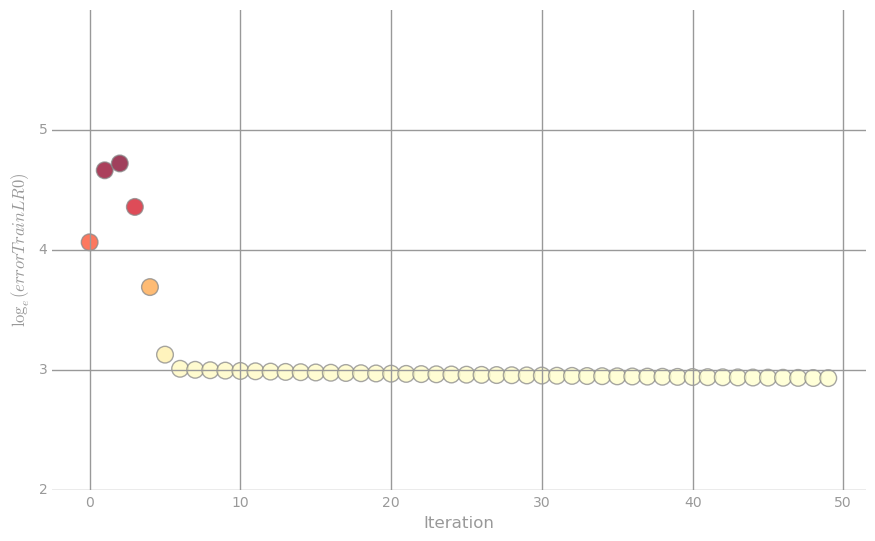

In [48]:
norm = Normalize()
clrs = cmap(np.asarray(norm(np.log(errorTrainLR0))))[:,0:3]

fig, ax = preparePlot(np.arange(0, 60, 10), np.arange(2, 6, 1))
ax.set_ylim(2, 6)
plt.scatter(range(0, numIters), np.log(errorTrainLR0), s=12**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xlabel('Iteration'), ax.set_ylabel(r'$\log_e(errorTrainLR0)$')
pass

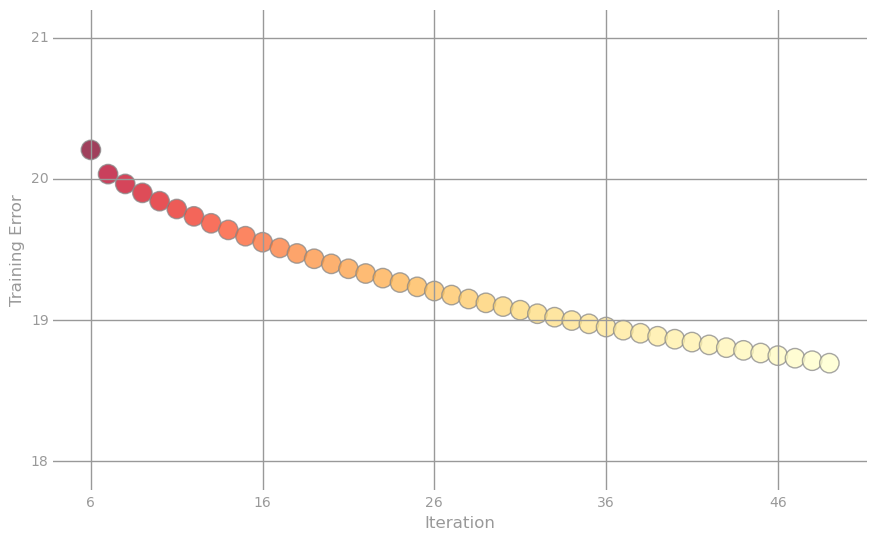

In [49]:
norm = Normalize()
clrs = cmap(np.asarray(norm(errorTrainLR0[6:])))[:,0:3]

fig, ax = preparePlot(np.arange(0, 60, 10), np.arange(17, 22, 1))
ax.set_ylim(17.8, 21.2)
plt.scatter(range(0, numIters-6), errorTrainLR0[6:], s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xticklabels(map(str, range(6, 66, 10)))
ax.set_xlabel('Iteration'), ax.set_ylabel(r'Training Error')
pass

### **Train using MLlib and perform grid search **

#### **LinearRegressionWithSGD` **
#### We're already doing better than the baseline model, but let's see if we can do better by adding an intercept, using regularization, and (based on the previous visualization) training for more iterations.  

In [50]:
from pyspark.mllib.regression import LinearRegressionWithSGD
numIters = 500  # iterations
alpha = 1.0  # step
miniBatchFrac = 1.0  # miniBatchFraction
reg = 1e-1  # regParam
regType = 'l2'  # regType
useIntercept = True  # intercept

In [51]:

firstModel = LinearRegressionWithSGD.train(parsedTrainData, iterations=numIters, step=alpha, miniBatchFraction=miniBatchFrac, regParam=reg, regType=regType, intercept=useIntercept)

weightsLR1 = firstModel.weights
interceptLR1 = firstModel.intercept
print weightsLR1, interceptLR1

[16.682292427,14.7439059559,-0.0935105608897,6.22080088829,4.01454261926,-3.30214858535,11.0403027232,2.67190962854,7.18925791279,4.46093254586,8.14950409475,2.75135810882] 13.3335907631


#### **Predict**


In [52]:

samplePoint = parsedTrainData.take(1)[0]
samplePrediction = firstModel.predict(samplePoint.features)
print samplePrediction

56.8013380112


#### ** Evaluate RMSE **

In [53]:
# TODO: Replace <FILL IN> with appropriate code
labelsAndPreds =parsedValData.map(lambda lp: (lp.label, firstModel.predict(lp.features)))
rmseValLR1 =calcRMSE(labelsAndPreds)

print ('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}' +
       '\n\tLR1 = {2:.3f}').format(rmseValBase, rmseValLR0, rmseValLR1)

Validation RMSE:
	Baseline = 21.586
	LR0 = 19.192
	LR1 = 19.691


#### ** Grid search **
#### We're already outperforming the baseline on the validation set by almost 2 years on average, but let's see if we can do better. Perform grid search to find a good regularization parameter.  Try `regParam` values `1e-10`, `1e-5`, and `1`.

In [54]:

bestRMSE = rmseValLR1
bestRegParam = reg
bestModel = firstModel

numIters = 500
alpha = 1.0
miniBatchFrac = 1.0
for reg in [1e-10, 1e-5, 1]:
    model = LinearRegressionWithSGD.train(parsedTrainData, numIters, alpha,
                                          miniBatchFrac, regParam=reg,
                                          regType='l2', intercept=True)
    labelsAndPreds = parsedValData.map(lambda lp: (lp.label, model.predict(lp.features)))
    rmseValGrid = calcRMSE(labelsAndPreds)
    print rmseValGrid

    if rmseValGrid < bestRMSE:
        bestRMSE = rmseValGrid
        bestRegParam = reg
        bestModel = model
rmseValLRGrid = bestRMSE

print ('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}\n\tLR1 = {2:.3f}\n' +
       '\tLRGrid = {3:.3f}').format(rmseValBase, rmseValLR0, rmseValLR1, rmseValLRGrid)

17.0171700716
17.0175981807
23.8007746698
Validation RMSE:
	Baseline = 21.586
	LR0 = 19.192
	LR1 = 19.691
	LRGrid = 17.017


#### ** Visualization: Best model's predictions**

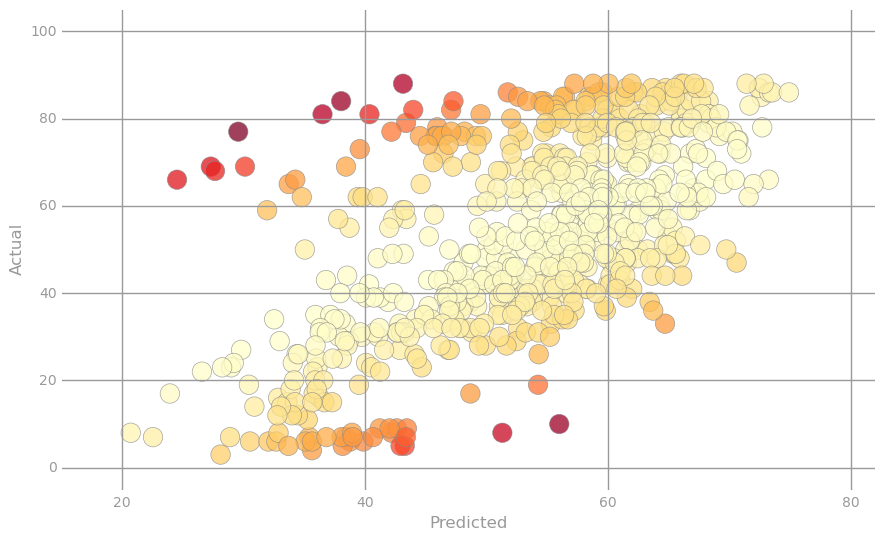

In [56]:
predictions = np.asarray(parsedValData
                         .map(lambda lp: bestModel.predict(lp.features))
                         .collect())
actual = np.asarray(parsedValData
                    .map(lambda lp: lp.label)
                    .collect())
error = np.asarray(parsedValData
                   .map(lambda lp: (lp.label, bestModel.predict(lp.features)))
                   .map(lambda (l, p): np.square(l-p))
                   .collect())

norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(0, 120, 20), np.arange(0, 120, 20))
ax.set_xlim(15, 82), ax.set_ylim(-5, 105)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=.5)
ax.set_xlabel('Predicted'), ax.set_ylabel(r'Actual')
pass

#### **Vary alpha and the number of iterations **

In [57]:
reg = bestRegParam
modelRMSEs = []

for alpha in [1e-5, 10]:
    for numIters in [5,500]:
        model = LinearRegressionWithSGD.train(parsedTrainData, numIters, alpha,
                                              miniBatchFrac, regParam=reg,
                                              regType='l2', intercept=True)
        labelsAndPreds = parsedValData.map(lambda lp: (lp.label, model.predict(lp.features)))
        rmseVal = calcRMSE(labelsAndPreds)
        print 'alpha = {0:.0e}, numIters = {1}, RMSE = {2:.3f}'.format(alpha, numIters, rmseVal)
        modelRMSEs.append(rmseVal)

alpha = 1e-05, numIters = 5, RMSE = 56.970
alpha = 1e-05, numIters = 500, RMSE = 56.893
alpha = 1e+01, numIters = 5, RMSE = 355124752.221
alpha = 1e+01, numIters = 500, RMSE = 33110728225678989137251839534941311488306376280786874812632607716020409015644103457295574688229365257796099669135380709376.000


In [58]:
modelRMSEs

[56.96970493238036,
 56.892948663998297,
 355124752.22122133,
 3.3110728225678989e+121]

#### **Visualization : Hyperparameter heat map **
#### Next, we perform a visualization of hyperparameter search using a larger set of hyperparameters (with precomputed results).

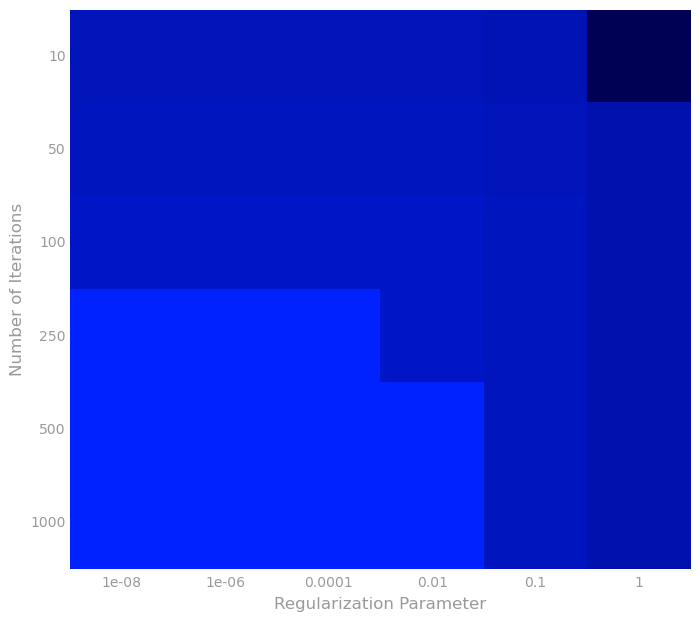

In [59]:
from matplotlib.colors import LinearSegmentedColormap

# Saved parameters and results, to save the time required to run 36 models
numItersParams = [10, 50, 100, 250, 500, 1000]
regParams = [1e-8, 1e-6, 1e-4, 1e-2, 1e-1, 1]
rmseVal = np.array([[  20.36769649,   20.36770128,   20.36818057,   20.41795354,  21.09778437,  301.54258421],
                    [  19.04948826,   19.0495    ,   19.05067418,   19.16517726,  19.97967727,   23.80077467],
                    [  18.40149024,   18.40150998,   18.40348326,   18.59457491,  19.82155716,   23.80077467],
                    [  17.5609346 ,   17.56096749,   17.56425511,   17.88442127,  19.71577117,   23.80077467],
                    [  17.0171705 ,   17.01721288,   17.02145207,   17.44510574,  19.69124734,   23.80077467],
                    [  16.58074813,   16.58079874,   16.58586512,   17.11466904,  19.6860931 ,   23.80077467]])

numRows, numCols = len(numItersParams), len(regParams)
rmseVal = np.array(rmseVal)
rmseVal.shape = (numRows, numCols)

fig, ax = preparePlot(np.arange(0, numCols, 1), np.arange(0, numRows, 1), figsize=(8, 7), hideLabels=True,
                      gridWidth=0.)
ax.set_xticklabels(regParams), ax.set_yticklabels(numItersParams)
ax.set_xlabel('Regularization Parameter'), ax.set_ylabel('Number of Iterations')

colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
image = plt.imshow(rmseVal,interpolation='nearest', aspect='auto',
                    cmap = colors)

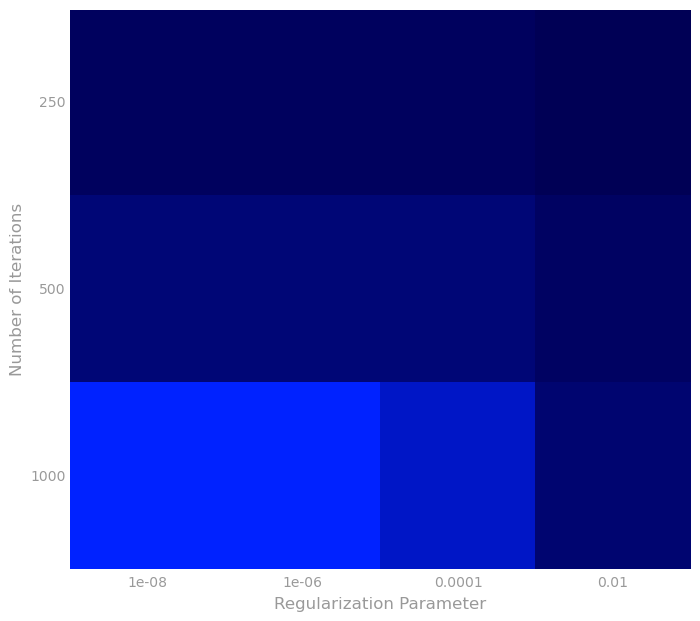

In [60]:
# Zoom into the bottom left
numItersParamsZoom, regParamsZoom = numItersParams[-3:], regParams[:4]
rmseValZoom = rmseVal[-3:, :4]

numRows, numCols = len(numItersParamsZoom), len(regParamsZoom)

fig, ax = preparePlot(np.arange(0, numCols, 1), np.arange(0, numRows, 1), figsize=(8, 7), hideLabels=True,
                      gridWidth=0.)
ax.set_xticklabels(regParamsZoom), ax.set_yticklabels(numItersParamsZoom)
ax.set_xlabel('Regularization Parameter'), ax.set_ylabel('Number of Iterations')

colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
image = plt.imshow(rmseValZoom,interpolation='nearest', aspect='auto',
                    cmap = colors)
pass

### ** Add interactions between features **

#### ** Add 2-way interactions **
For features [x, y] the two-way interactions would be [x^2, x*y, y*x, y^2] and these would be appended to the original [x, y] feature list.

In [63]:
# TODO: Replace <FILL IN> with appropriate code
import itertools

def twoWayInteractions(lp):
    cartesian_product_iterator = [item for item in itertools.product(lp.features, lp.features)]
    cartesian_product = map(lambda x: np.prod(x), cartesian_product_iterator)
    return LabeledPoint(lp.label, np.hstack((lp.features, cartesian_product)))

print twoWayInteractions(LabeledPoint(0.0, [2, 3]))

# Transform the existing train, validation, and test sets to include two-way interactions.
trainDataInteract = parsedTrainData.map(twoWayInteractions)
valDataInteract = parsedValData.map(twoWayInteractions)
testDataInteract = parsedTestData.map(twoWayInteractions)

(0.0,[2.0,3.0,4.0,6.0,6.0,9.0])


#### ** Build interaction model **


In [65]:

numIters = 500
alpha = 1.0
miniBatchFrac = 1.0
reg = 1e-10

modelInteract = LinearRegressionWithSGD.train(trainDataInteract, numIters, alpha,
                                              miniBatchFrac, regParam=reg,
                                              regType='l2', intercept=True)
labelsAndPredsInteract = valDataInteract.map(lambda lp: (lp.label, modelInteract.predict(lp.features)))
rmseValInteract = calcRMSE(labelsAndPredsInteract)

print ('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}\n\tLR1 = {2:.3f}\n\tLRGrid = ' +
       '{3:.3f}\n\tLRInteract = {4:.3f}').format(rmseValBase, rmseValLR0, rmseValLR1,
                                                 rmseValLRGrid, rmseValInteract)

Validation RMSE:
	Baseline = 21.586
	LR0 = 19.192
	LR1 = 19.691
	LRGrid = 17.017
	LRInteract = 15.690


#### **Evaluate interaction model on test data **


In [66]:
labelsAndPredsTest = testDataInteract.map(lambda lp: (lp.label, modelInteract.predict(lp.features)))
rmseTestInteract = calcRMSE(labelsAndPredsTest)

print ('Test RMSE:\n\tBaseline = {0:.3f}\n\tLRInteract = {1:.3f}'
       .format(rmseTestBase, rmseTestInteract))

Test RMSE:
	Baseline = 22.137
	LRInteract = 16.327


In [69]:
po = np.arange(valDataInteract.count())

In [70]:
predictions = np.asarray(valDataInteract
                         .map(lambda lp: modelInteract.predict(lp.features))
                         .collect())
actual = np.asarray(valDataInteract
                    .map(lambda lp: lp.label)
                    .collect())

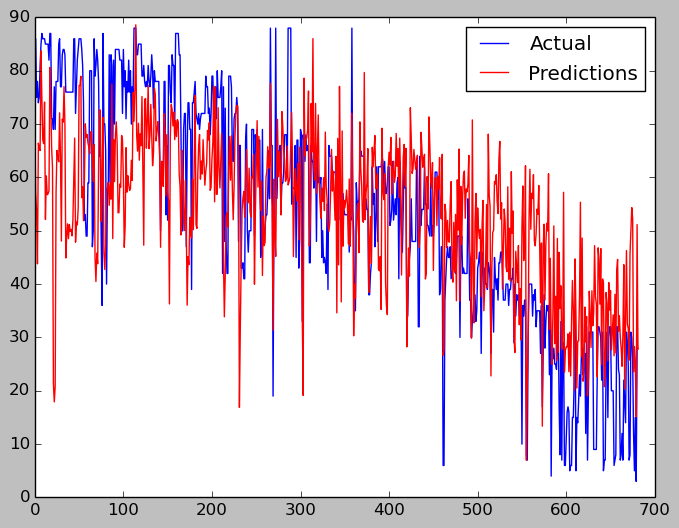

In [73]:
plt.plot(po,actual,c='b',label='Actual')
pass
plt.plot(po,predictions,c='r',label='Predictions')
pass
plt.legend(loc="upper right")
pass

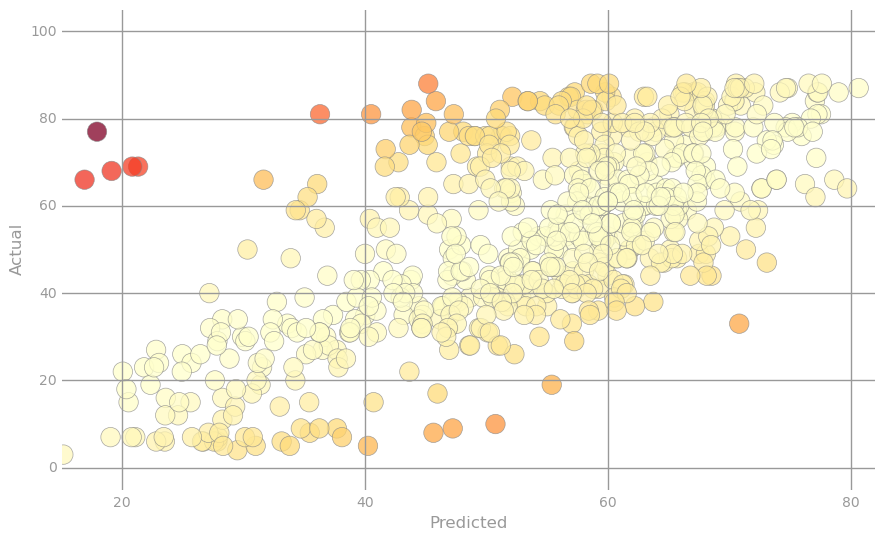

In [72]:
error = np.asarray(valDataInteract
                   .map(lambda lp: (lp.label, modelInteract.predict(lp.features)))
                   .map(lambda (l, p): np.square(l-p))
                   .collect())

norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(0, 120, 20), np.arange(0, 120, 20))
ax.set_xlim(15, 82), ax.set_ylim(-5, 105)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=.5)
ax.set_xlabel('Predicted'), ax.set_ylabel(r'Actual')
pass